## imports

In [187]:
import pandas as pd
import requests 
import json
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression
import datetime as dt

from mizani.breaks import date_breaks
from mizani.formatters import date_format


## methods

In [188]:
#Funktion um Daten aus der Datenbank zu holen (Immer nur 10'000 Reihen aufs mal)
def get_data_all(x) -> pd.DataFrame:
    r = requests.get('https://glusfqycvwrucp9-db202202211424.adb.eu-zurich-1.oraclecloudapps.com/ords/sensor_datalake2/sens/any_sensor_data_entry/',auth=('SENSOR_DATALAKE2', 'smarTclassrooM2Da'), params={"limit":50000, "offset":x * 10_000})

    df = pd.json_normalize(r.json()["items"])

    df.set_index(pd.DatetimeIndex(df["inserttime"]), inplace=True)
    df.drop("inserttime", axis=1, inplace=True)
    df.sort_index(inplace=True)

    return df

#Funktion um erste Plots der Daten zu machen
def show_data(data:pd.DataFrame):
    x = data.index.values

    device1_hum = data["device1humidity"].values
    device2_hum = data["device2humidity"].values
    device3_hum = data["device3humidity"].values

    device1_co2 = data["device1co2"].values
    device2_co2 = data["device2co2"].values
    device3_co2 = data["device3co2"].values

    device1_temp = data["device1temp"].values
    device2_temp = data["device2temp"].values
    device3_temp = data["device3temp"].values

    device3_window1 = data["device3window1a"].values
    device3_window2 = data["device3window2b"].values
    device3_window3 = data["device3window3a"].values
    device3_window4 = data["device3window4b"].values
    device3_window5 = data["device3window5a"].values

    device1_light = data["device1light"].values
    device2_light = data["device2light"].values
    device3_light = data["device3light"].values

    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(15,15))

    ax[0].set_title("Humidity")
    ax[0].plot(x, device1_hum, label="Device1")
    ax[0].plot(x, device2_hum, label="Device2")
    ax[0].plot(x, device3_hum, label="Device3")
    ax[0].legend(loc="right")
    ax[0].set_ylabel("Humidity in %")

    ax[1].set_title("CO2")
    ax[1].plot(x, device1_co2, label="Device1")
    ax[1].plot(x, device2_co2, label="Device2")
    ax[1].plot(x, device3_co2, label="Device3")
    ax[1].legend(loc="right")
    ax[1].set_ylabel("CO2 in ppM")

    ax[2].set_title("Temperature")
    ax[2].plot(x, device1_temp, label="Device1")
    ax[2].plot(x, device2_temp, label="Device2")
    ax[2].plot(x, device3_temp, label="Device3")
    ax[2].legend(loc="right")
    ax[2].set_ylabel("Temperature in °C")

    ax[3].set_title("Lightstrength")
    ax[3].plot(x, device1_light, label="Device1")
    ax[3].plot(x, device2_light, label="Device2")
    ax[3].plot(x, device3_light, label="Device3")
    ax[3].legend(loc="right")
    ax[3].set_ylabel("Lightstrength in lumen")

    ax[4].set_title("Window")
    ax[4].plot(x, device3_window1, label="Window1")
    ax[4].plot(x, device3_window2, label="Window2")
    ax[4].plot(x, device3_window3, label="Window3")
    ax[4].plot(x, device3_window4, label="Window4")
    ax[4].plot(x, device3_window5, label="Window5")
    ax[4].legend(loc="right")
    ax[4].set_yticks([0, 1])
    ax[4].set_yticklabels(["closed", "open"])
    ax[4].set_ylabel("State [open; closed]")


In [189]:
#Da immer nur 10'000 Zeilen mit einer Abfrage geholt werden können, werden diese in mehrere df gespeichert und danach zusammengeführt.
#In den Klammern immer die Nummer des jeweiligen df angeben (Dann nimmt immer die nächsten Zeilen)
df0 = get_data_all(0)
df1 = get_data_all(1)
df2 = get_data_all(2)
df3 = get_data_all(3)
df4 = get_data_all(4)

#df Zusammenführen
df = pd.concat([df0, df1, df2, df3, df4], axis=0)

#Sicherheitshalber nochmals sortieren
df = df.sort_values(by="inserttime")

#2 Neue Spalten hinzufügen, für Anzahl Personen im Klassenzimmer und Fächer
df = df.assign(numberOfPeople = 0, subject = "Nichts")

In [190]:
#df erwitern anhand Klassenliste (welche von den Lehrern ausgefüllt wurde)
#04.04.2022
mask = (df.index > pd.to_datetime("04042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 18
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("04042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 16
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("04042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 17
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("04042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 16
df.loc[mask, "subject"] = "Allg."
#05.04.2022
mask = (df.index > pd.to_datetime("05042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 21
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("05042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Mittag"

mask = (df.index > pd.to_datetime("05042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 14:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 19
df.loc[mask, "subject"] = "Französisch"
#06.04.2022
mask = (df.index > pd.to_datetime("06042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 08:20:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 19
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("06042022 10:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 8
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("06042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Pause"

mask = (df.index > pd.to_datetime("06042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("06042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("06042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "Mittag"

mask = (df.index > pd.to_datetime("06042022 14:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 15:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 4
df.loc[mask, "subject"] = "Elterngespräch"
#07.04.2022
mask = (df.index > pd.to_datetime("07042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 08:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 20
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("07042022 08:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("07042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 20
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("07042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("07042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"
#08.04.2022
mask = (df.index > pd.to_datetime("08042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Französisch"

mask = (df.index > pd.to_datetime("08042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 09:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("08042022 09:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 23
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("08042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("08042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "Mittag"
#11.04.2022
mask = (df.index > pd.to_datetime("11042022 12:40:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("11042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"

mask = (df.index > pd.to_datetime("11042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("11042022 15:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "3 Tageblock"

mask = (df.index > pd.to_datetime("11042022 15:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("11042022 18:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"
#12.04.2022
mask = (df.index > pd.to_datetime("12042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("12042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"

mask = (df.index > pd.to_datetime("12042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("12042022 12:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 3
df.loc[mask, "subject"] = "3 Tageblock"
#13.04.2022
mask = (df.index > pd.to_datetime("13042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("13042022 15:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"
#25.04.2022
mask = (df.index > pd.to_datetime("25042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 19
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 17
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 18
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 17
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 12:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 16:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Allgemein"
#26.04.2022
mask = (df.index > pd.to_datetime("26042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 09:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 21
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("26042022 09:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 10:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 12
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 13
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 11:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 8
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "Vorleseeinheiten"
#27.04.2022
mask = (df.index > pd.to_datetime("27042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 08:20:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("27042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("27042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("27042022 17:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 17:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Vorleseeinheiten"
#28.04.2022
mask = (df.index > pd.to_datetime("28042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 13
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("28042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Abteilung"
#29.04.2022
mask = (df.index > pd.to_datetime("29042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 23
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("29042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("29042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

,entryid,device1humidity,device1co2,device1temp,device2humidity,device2co2,device2temp,device3humidity,device3co2,device3temp,...,device3window4b,device3window5a,device1light,device2light,device3light,device1battery,device2battery,device3battery,numberOfPeople,subject
inserttime,,,,,,,,,,,,,,,,,,,,,
2022-04-03 16:57:49+00:00,537,28.3035,360.727,22.6394,29.3671,433.828,22.4445,27.2156,464.521,24.6021,...,0.0,0.0,10.57170,9.30525,12.9165,None,None,None,0,Nichts
2022-04-03 16:59:04+00:00,538,28.4836,361.801,22.6688,29.3304,433.614,22.5032,27.1317,462.388,24.6315,...,0.0,0.0,10.38860,8.81055,12.9165,None,None,None,0,Nichts
2022-04-03 17:00:14+00:00,539,28.4225,367.020,22.6955,29.4586,433.403,22.5460,27.1591,462.645,24.6315,...,0.0,0.0,9.96814,8.87486,12.9314,None,None,None,0,Nichts
2022-04-03 17:01:26+00:00,540,28.3279,369.415,22.7382,29.3198,441.238,22.5460,27.2278,464.077,24.6021,...,0.0,0.0,9.59712,8.45932,12.9413,None,None,None,0,Nichts
2022-04-03 17:02:37+00:00,541,28.3096,367.818,22.7249,29.2557,444.417,22.6020,27.2278,466.831,24.6021,...,0.0,0.0,9.25578,8.06851,12.2883,None,None,None,0,Nichts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 09:33:05+00:00,45433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Nichts
2022-05-03 09:33:46+00:00,45434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Nichts
2022-05-03 09:34:27+00:00,45435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Nichts


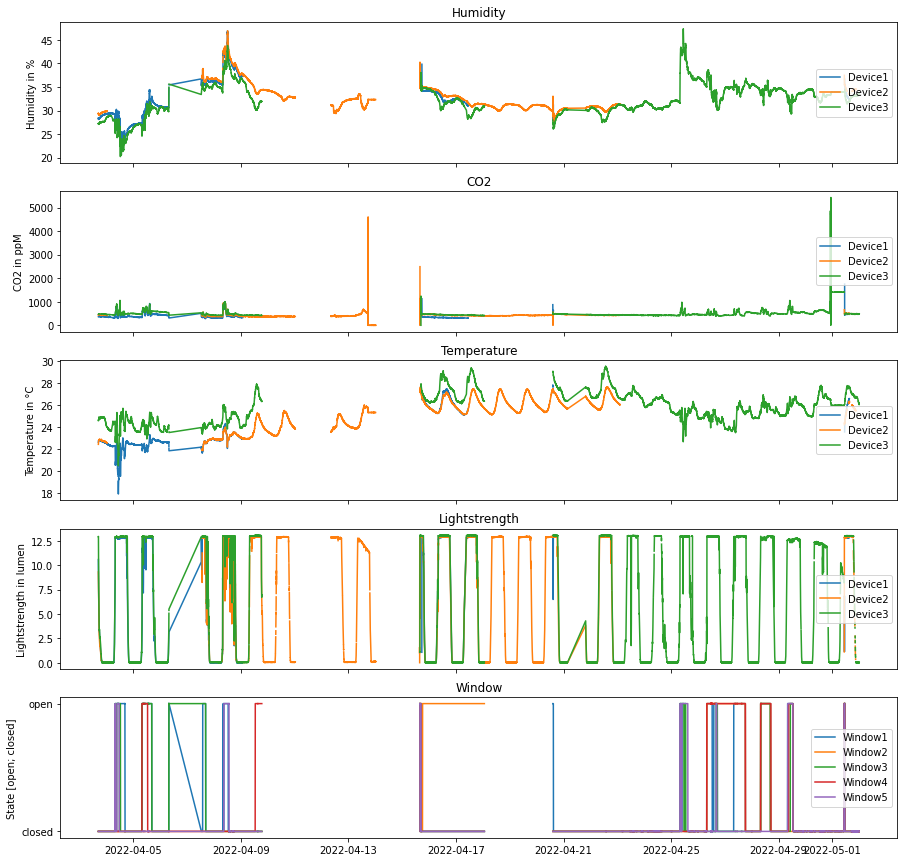

In [191]:
#Daten plotten für den ersten Blick
show_data(df)
df

In [192]:
#Neue Spalten erstellen (Wie viel Fenster Offen/Wieviel Gekippt, was für eine Kombination?)
df = df.assign(fensterOffen = 0)
df = df.assign(fensterGekippt = 0)
df = df.assign(fensterKombination = 0)

df["fensterGekippt"]        = df["device3window2b"] + df["device3window4b"]
df["fensterOffen"]          = df["device3window1a"] + df["device3window3a"] + df["device3window5a"]

In [193]:
#Kombinationen der Fenster erstellen

#0 Fenster gekippt & 0 Fenster offen
mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 0)
df.loc[mask, "fensterKombination"] = "0 gekippt & 0 offen"

#0 Fenster gekippt & 1 Fenster offen
mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 1)
df.loc[mask, "fensterKombination"] = "0 gekippt & 1 offen"

#0 Fenster gekippt & 2 Fenster offen
mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 2)
df.loc[mask, "fensterKombination"] = "0 gekippt & 2 offen"

#0 Fenster gekippt & 3 Fenster offen
mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 3)
df.loc[mask, "fensterKombination"] = "0 gekippt & 3 offen"

#1 Fenster gekippt & 0 Fenster offen
mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 0)
df.loc[mask, "fensterKombination"] = "1 gekippt & 0 offen"

#1 Fenster gekippt & 1 Fenster offen
mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 1)
df.loc[mask, "fensterKombination"] = "1 gekippt & 1 offen"

#1 Fenster gekippt & 2 Fenster offen
mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 2)
df.loc[mask, "fensterKombination"] = "1 gekippt & 2 offen"

#1 Fenster gekippt & 3 Fenster offen
mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 3)
df.loc[mask, "fensterKombination"] = "1 gekippt & 3 offen"

#2 Fenster gekippt & 0 Fenster offen
mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 0)
df.loc[mask, "fensterKombination"] = "2 gekippt & 0 offen"

#2 Fenster gekippt & 1 Fenster offen
mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 1)
df.loc[mask, "fensterKombination"] = "2 gekippt & 1 offen"

#2 Fenster gekippt & 2 Fenster offen
mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 2)
df.loc[mask, "fensterKombination"] = "2 gekippt & 2 offen"

#2 Fenster gekippt & 3 Fenster offen
mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 3)
df.loc[mask, "fensterKombination"] = "2 gekippt & 3 offen"

#Überall wo wir keine Daten haben, als solche Markieren
df.loc[df["fensterKombination"] == 0, "fensterKombination"] = "Keine Daten"

## Plots

In [194]:
#df Erstellen vom 04.04.2022
mask = (df.index > pd.to_datetime("04042022 00:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("04042022 23:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df0404 = df.loc[mask]

df0404.reset_index(inplace=True)

df0404["fensterKombination"] = df0404["fensterKombination"].astype("category")

#Um den Hintergrund des Plots zu verändern, diese 3 df erstellen
start   = df0404["inserttime"][:-1]
end     = df0404["inserttime"][1:]
colors  = df0404["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

#Die letzten 3 df zusammenführen
dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df0404 = df0404[:-1]

<ipython-input-194-3c234c5b93c8>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



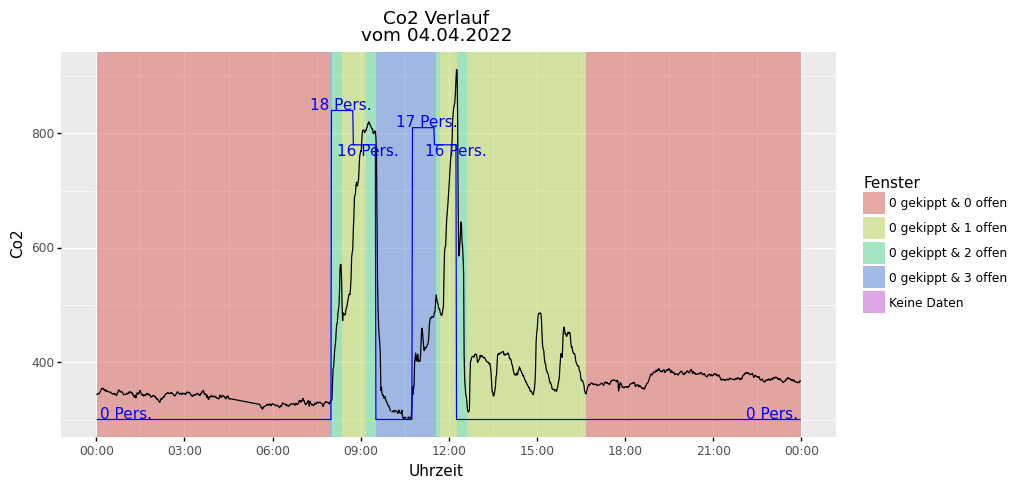

<ggplot: (8762213455321)>

In [195]:
#Plot vom 04.04.2022
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_line(df0404, aes("inserttime", "device1co2"))
    + geom_line(df0404, aes("inserttime", "30*numberOfPeople+300"), color = "blue")
    + scale_x_date(date_labels = "%H:%M")
    + labs(title = "Co2 Verlauf\nvom 04.04.2022",x = "Uhrzeit", y = "Co2", fill = "Fenster")
    + theme(figure_size=(10, 5))
    + annotate("text", x=pd.Timestamp("2022-04-04 01:00:00"), y = 310, label="0 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-04 08:20:00"), y = 850, label="18 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-04 12:15:00"), y = 770, label="16 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-04 09:15:00"), y = 770, label="16 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-04 11:15:00"), y = 820, label="17 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-04 23:00:00"), y = 310, label="0 Pers.", color = "blue")
    )

In [196]:
#df Erstellen vom 08.04.2022
mask = (df.index > pd.to_datetime("08042022 00:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("08042022 23:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df0804 = df.loc[mask]

df0804.reset_index(inplace=True)

df0804["fensterKombination"] = df0804["fensterKombination"].astype("category")

#Um den Hintergrund des Plots zu verändern, diese 3 df erstellen
start   = df0804["inserttime"][:-1]
end     = df0804["inserttime"][1:]
colors  = df0804["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

#Die letzten 3 df zusammenführen
dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df0804 = df0804[:-1]

<ipython-input-196-27fa745d8d2a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



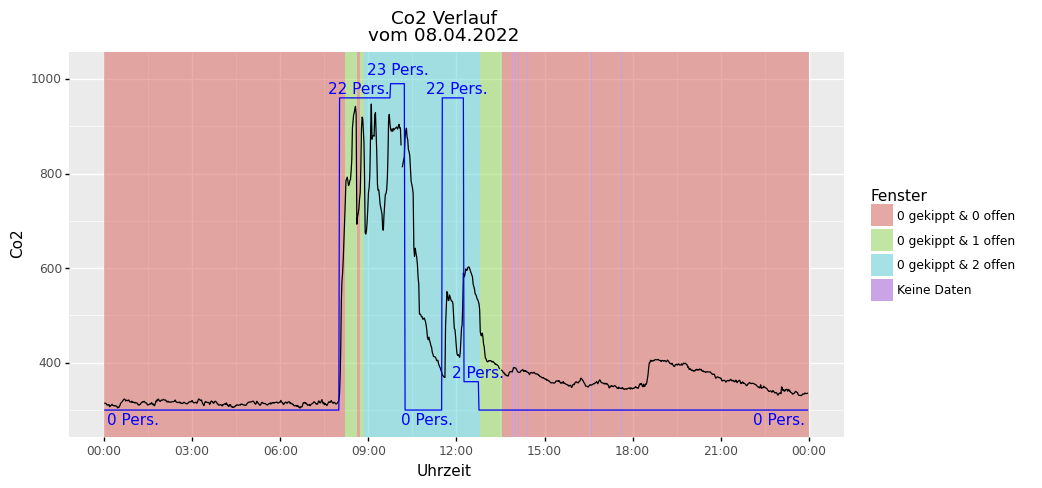

<ggplot: (8762213016179)>

In [197]:
#Plot vom 08.04.2022
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_line(df0804, aes("inserttime", "device1co2"))
    + geom_line(df0804, aes("inserttime", "30*numberOfPeople+300"), color = "blue")
    + scale_x_date(date_labels = "%H:%M")
    + labs(title = "Co2 Verlauf\nvom 08.04.2022",x = "Uhrzeit", y = "Co2", fill = "Fenster")
    + theme(figure_size=(10, 5))
    + annotate("text", x=pd.Timestamp("2022-04-08 01:00:00"), y = 280, label="0 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-08 08:40:00"), y = 980, label="22 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-08 10:00:00"), y = 1020, label="23 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-08 11:00:00"), y = 280, label="0 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-08 12:00:00"), y = 980, label="22 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-08 12:45:00"), y = 380, label="2 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-08 23:00:00"), y = 280, label="0 Pers.", color = "blue")
    )

In [198]:
#df Erstellen vom 27.04.2022
mask = (df.index > pd.to_datetime("27042022 00:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("27042022 23:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df2704 = df.loc[mask]

df2704.reset_index(inplace=True)

df2704["fensterKombination"] = df2704["fensterKombination"].astype("category")

#Um den Hintergrund des Plots zu verändern, diese 3 df erstellen
start   = df2704["inserttime"][:-1]
end     = df2704["inserttime"][1:]
colors  = df2704["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

#Die letzten 3 df zusammenführen
dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df2704 = df2704[:-1]

<ipython-input-198-8ff9dcdc5a68>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/opt/anaconda3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning:

geom_path: Removed 1 rows containing missing values.



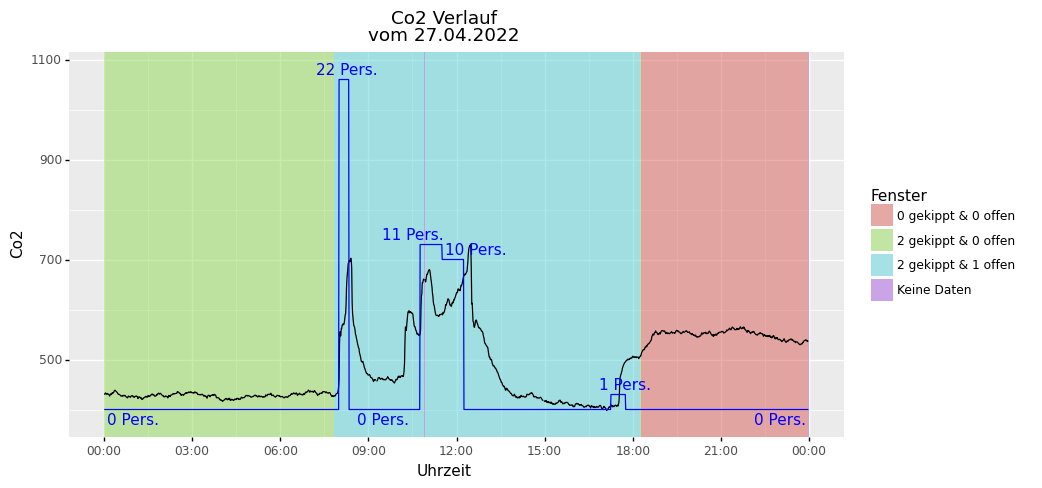

<ggplot: (8762229808842)>

In [199]:
#Plot vom 27.04.2022
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_line(df2704, aes("inserttime", "device3co2"))
    + geom_line(df2704, aes("inserttime", "30*numberOfPeople+400"), color = "blue")
    + scale_x_date(date_labels = "%H:%M")
    + labs(title = "Co2 Verlauf\nvom 27.04.2022",x = "Uhrzeit", y = "Co2", fill = "Fenster")
    + theme(figure_size=(10, 5))
    + annotate("text", x=pd.Timestamp("2022-04-27 01:00:00"), y = 380, label="0 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-27 08:15:00"), y = 1080, label="22 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-27 09:30:00"), y = 380, label="0 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-27 10:30:00"), y = 750, label="11 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-27 12:40:00"), y = 720, label="10 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-27 17:45:00"), y = 450, label="1 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-27 23:00:00"), y = 380, label="0 Pers.", color = "blue")
    )

In [200]:
#df Erstellen vom 05.04.2022 08:00 - 08:25 Uhr
mask = (df.index > pd.to_datetime("05042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("05042022 08:25:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df0504_0800 = df.loc[mask]
df0504_0800 = df0504_0800.reset_index()
df0504_0800["inserttime"] = df0504_0800["inserttime"] - DateOffset(months=3, days=4, hours=8)
df0504_0800["device3co2"] = df0504_0800["device3co2"] - df0504_0800["device3co2"][0]

#df Erstellen vom 05.04.2022 10:45 - 11:10 Uhr
mask = (df.index > pd.to_datetime("05042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("05042022 11:10:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df0504_1045 = df.loc[mask]
df0504_1045 = df0504_1045.reset_index()
df0504_1045["inserttime"] = df0504_1045["inserttime"] - DateOffset(months=3, days=4, hours=10.75)
df0504_1045["device3co2"] = df0504_1045["device3co2"] - df0504_1045["device3co2"][0]

#df Zusammenführen
df12 = pd.DataFrame({
    "inserttime":           np.hstack([df0504_0800["inserttime"],     df0504_1045["inserttime"]]),
    "device3co2":           np.hstack([df0504_0800["device3co2"],     df0504_1045["device3co2"]]),
    "numberOfPeople":       np.hstack([df0504_0800["numberOfPeople"], df0504_1045["numberOfPeople"]])
})

df12["numberOfPeople"] = df12["numberOfPeople"].astype("category")


#df Erstellen vom 05.04.2022 08:00 - 08:25 Uhr
mask = (df.index > pd.to_datetime("27042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("27042022 08:20:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df2704_0800 = df.loc[mask]
df2704_0800 = df2704_0800.reset_index()
df2704_0800["inserttime"] = df2704_0800["inserttime"] - DateOffset(months=3, days=26, hours=8)
df2704_0800["device3co2"] = df2704_0800["device3co2"] - df2704_0800["device3co2"][0]

#df Erstellen vom 05.04.2022 10:45 - 11:10 Uhr
mask = (df.index > pd.to_datetime("27042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("27042022 11:05:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df2704_1045 = df.loc[mask]
df2704_1045 = df2704_1045.reset_index()
df2704_1045["inserttime"] = df2704_1045["inserttime"] - DateOffset(months=3, days=26, hours=10.75)
df2704_1045["device3co2"] = df2704_1045["device3co2"] - df2704_1045["device3co2"][0]

#df Zusammenführen
df21 = pd.DataFrame({
    "inserttime":           np.hstack([df2704_0800["inserttime"],         df2704_1045["inserttime"]]),
    "device3co2":           np.hstack([df2704_0800["device3co2"],         df2704_1045["device3co2"]]),
    "numberOfPeople":       np.hstack([df2704_0800["numberOfPeople"],     df2704_1045["numberOfPeople"]])
})

df21["numberOfPeople"] = df21["numberOfPeople"].astype("category")

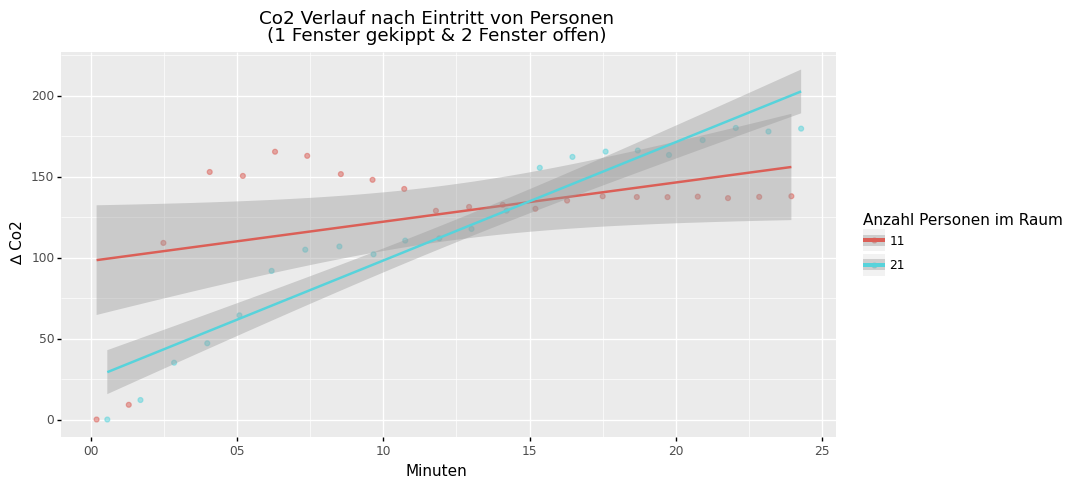

<ggplot: (8762215752376)>

In [201]:
#1. Plot
(ggplot()
    + geom_point(df12, aes("inserttime", "device3co2", color = "numberOfPeople"), alpha = 0.5)
    + geom_smooth(df12, aes("inserttime", "device3co2", color = "numberOfPeople"), span = 1, se = True, method="lm")
    + scale_x_date(date_labels = "%M")
    + labs(title = "Co2 Verlauf nach Eintritt von Personen\n(1 Fenster gekippt & 2 Fenster offen)",x = "Minuten", y = "∆ Co2", color = "Anzahl Personen im Raum")
    + theme(figure_size=(10, 5))
    )

/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning:

geom_point : Removed 1 rows containing missing values.



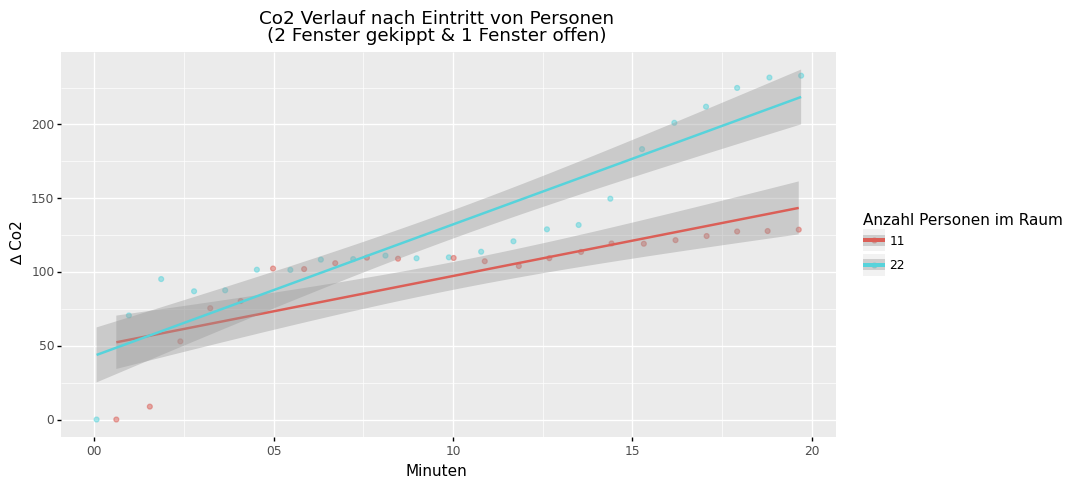

<ggplot: (8762184383115)>

In [202]:
#2. Plot
(ggplot()
    + geom_point(df21, aes("inserttime", "device3co2", color = "numberOfPeople"), alpha = 0.5)
    + geom_smooth(df21, aes("inserttime", "device3co2", color = "numberOfPeople"), span = 1, se = True, method="lm")
    + scale_x_date(date_labels = "%M")
    + labs(title = "Co2 Verlauf nach Eintritt von Personen\n(2 Fenster gekippt & 1 Fenster offen)",x = "Minuten", y = "∆ Co2", color = "Anzahl Personen im Raum")
    + theme(figure_size=(10, 5))
    )

In [203]:
#df Erstellen
mask = (df.index > pd.to_datetime("08042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("08042022 08:12:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

dffit = df.loc[mask]

dffit.reset_index(inplace=True)

dffit["fensterKombination"] = dffit["fensterKombination"].astype("category")

start   = dffit["inserttime"][:-1]
end     = dffit["inserttime"][1:]
colors  = dffit["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

dffit = dffit[:-1]
dffit = dffit.reset_index()
dffit["index"] = dffit["index"] + 4


<ipython-input-203-706ff6d787d4>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [204]:
#df Erstellen vom 08.04.2022 07:55 - 08:20 Uhr
mask = (df.index > pd.to_datetime("08042022 07:55:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("08042022 08:20:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df0804 = df.loc[mask]

df0804.reset_index(inplace=True)

df0804["fensterKombination"] = df0804["fensterKombination"].astype("category")

start   = df0804.index.values[:-1]
end     = df0804.index.values[1:]
colors  = df0804["fensterKombination"][:-1]

colors.reset_index(inplace = True, drop = True)

dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df0804 = df0804[:-1]
df0804 = df0804.reset_index()

<ipython-input-204-36211f98fe78>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [205]:
#Lineare Regression durchführen
x = dffit["index"].values.reshape(-1,1)
y = dffit["device3co2"].values.reshape(-1,1)
model = LinearRegression().fit(x, y)

r_square = model.score(x, y)
print("r^2 =", r_square)
print("intercept (Konstante) =", model.intercept_)
print("slope (Steigung) =", model.coef_)

r^2 = 0.8764622336792148
intercept (Konstante) = [391.52457143]
slope (Steigung) = [[25.69652381]]


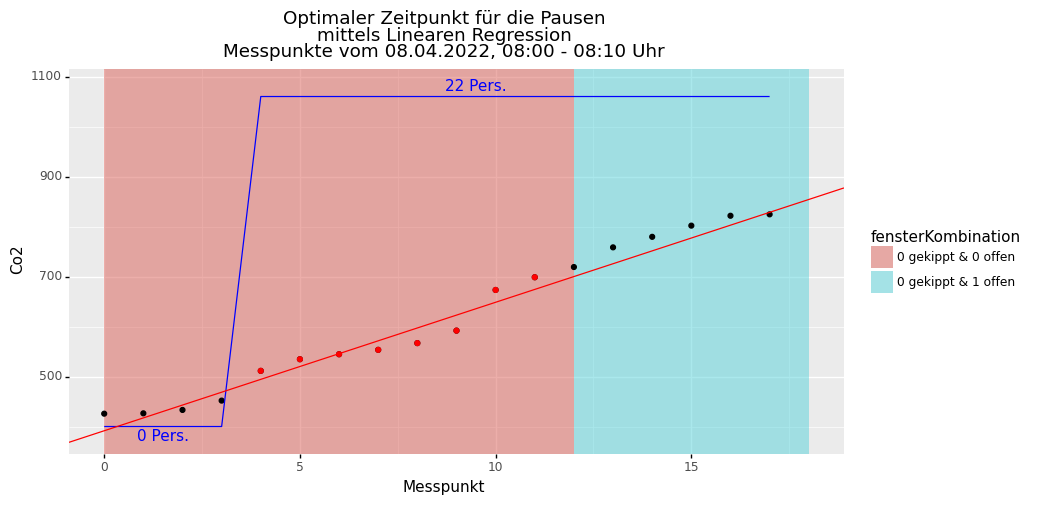

<ggplot: (8762183969705)>

In [206]:
#Plot
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_point(df0804, aes("index", "device3co2"))
    + geom_point(dffit, aes("index", "device3co2"), color = "red")
    + geom_line(df0804, aes("index", "30*numberOfPeople+400"), color = "blue")
    + geom_abline(intercept = 391.52457143, slope = 25.69652381, color = "red")
    + labs(title = "Optimaler Zeitpunkt für die Pausen\nmittels Linearen Regression\nMesspunkte vom 08.04.2022, 08:00 - 08:10 Uhr",x = "Messpunkt", y = "Co2")
    + theme(figure_size=(10, 5))
    + annotate("text", x = 1.5, y = 380, label="0 Pers.", color = "blue")
    + annotate("text", x = 9.5, y = 1080, label="22 Pers.", color = "blue")
)

In [207]:
#df Erstellen vom 04.04.2022 09:25 - 09:50 Uhr
mask = (df.index > pd.to_datetime("04042022 09:25:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("04042022 09:50:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df0404 = df.loc[mask]

df0404.reset_index(inplace=True)

df0404["fensterKombination"] = df0404["fensterKombination"].astype("category")

start   = df0404["inserttime"][:-1]
end     = df0404["inserttime"][1:]
colors  = df0404["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df0404 = df0404[:-1]
df0404 = df0404.reset_index()

<ipython-input-207-bd309bdb8840>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



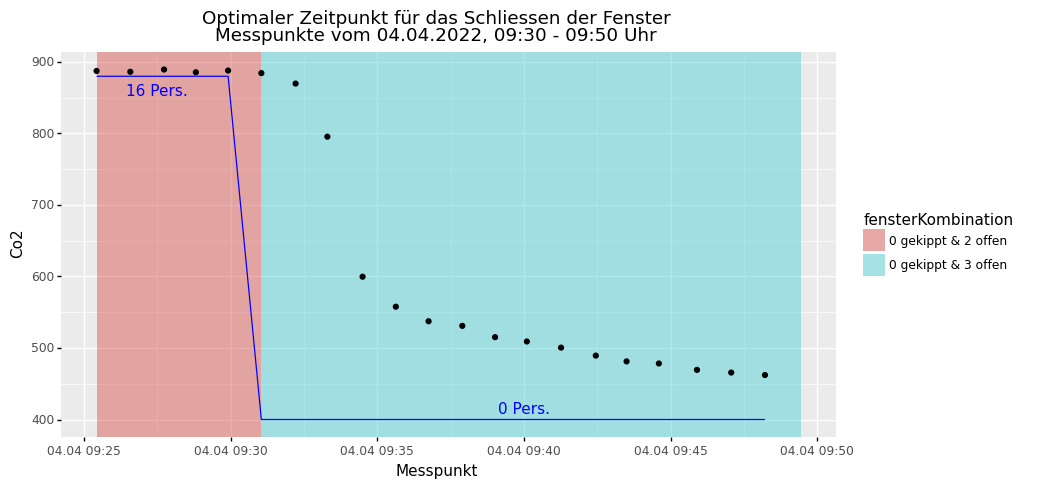

<ggplot: (8762229668349)>

In [208]:
#Plot
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_point(df0404, aes("inserttime", "device3co2"))
    + geom_line(df0404, aes("inserttime", "30*numberOfPeople+400"), color = "blue")
    + scale_x_date(date_labels = "%d.%m %H:%M")
    + labs(title = "Optimaler Zeitpunkt für das Schliessen der Fenster\nMesspunkte vom 04.04.2022, 09:30 - 09:50 Uhr",x = "Messpunkt", y = "Co2")
    + theme(figure_size=(10, 5))
    + annotate("text", x=pd.Timestamp("2022-04-04 09:27:30"), y = 860, label="16 Pers.", color = "blue")
    + annotate("text", x=pd.Timestamp("2022-04-04 09:40:00"), y = 415, label="0 Pers.", color = "blue")
    )

In [209]:
#df Erstellen vom 28.04.2022 09:22 - 10:49 Uhr
mask = (df.index > pd.to_datetime("04042022 09:22:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
       (df.index < pd.to_datetime("04042022 10:48:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df0404 = df.loc[mask]
Time = df0404.index.values

df0404['fensterOffen'] = df0404['fensterOffen'].astype('category')

#Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Time,
    y=df0404['device3co2'],
    name="Co2"
))


fig.add_trace(go.Line(
    x=Time,
    y=df0404['device3temp'],
    name="Raumtemperatur",
    yaxis="y2"
))

fig.add_trace(go.Line(
    x=Time,
    y=df0404['fensterOffen'],
    name="Anzahl Fenster Offen",
    yaxis="y3"
))


# Create axis objects
fig.update_layout(
    xaxis=dict(
        domain=[0.1, 0.85]
    ),
    yaxis=dict(
        title="CO2",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        ),
        position = 0.1
    ),
    yaxis2=dict(
        title="Raumtemperatur",
        titlefont=dict(
            color="#d62728"
        ),
        tickfont=dict(
            color="#d62728"
        ),
        anchor="free",
        overlaying="y",
        side="left",
        position = 0
    ),
    yaxis3=dict(
        title="Anzahl Personen",
        titlefont=dict(
            
        ),
        tickfont=dict(
            
        ),
        anchor="x",
        overlaying="y",
        side="right",
        position = 0.95
    )
)

# Update layout properties
fig.update_layout(
    title_text="Messungen 04.04.22",
    width = 1000
)

fig.show()

<ipython-input-209-4f328ccd3f30>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [210]:
#df Erstellen vom 28.04.2022 06:00 - 19:00 Uhr
mask = (df.index > pd.to_datetime("28042022 06:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 18:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

fig = make_subplots(specs=[[{"secondary_y": True}]])
df2804 = df.loc[mask]
Time = df2804.index.values

#Plot
fig.add_trace(
    go.Line(x= Time, y = df2804['device3co2'], name='Co2-Gehalt')
)

fig.add_trace(
    go.Line(x=Time, y=df2804['device3temp'] , name="Luftfeuchtigkeit", line=dict(color="red", width = 0.7)),
    secondary_y=True, 
)

# Add figure title
fig.update_layout(
    title_text="Tageswerte 28.04."
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Co2</b>", secondary_y=False, color = 'blue')
fig.update_yaxes(title_text="<b>Grad Celsius</b>", secondary_y=True, color = 'red')

fig.update_layout(
    title_text="Messungen 28.04.22",
    width = 800
)

fig.show()

In [211]:
#df Erstellen vom 28.04.2022 06:00 - 19:00 Uhr
mask = (df.index > pd.to_datetime("28042022 06:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 18:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

fig = make_subplots(specs=[[{"secondary_y": True}]])
df2804 = df.loc[mask]
Time = df2804.index.values

#Plot
fig.add_trace(
    go.Line(x= Time, y = df2804['device3co2'], name='Co2-Gehalt')
)

fig.add_trace(
    go.Scatter(x=Time, y=df2804['numberOfPeople'] , name="Personen im Raum"),
    secondary_y=True, 
)

# Add figure title
fig.update_layout(
    title_text="Tageswerte 28.04."
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Co2</b>", secondary_y=False, color = 'blue')
fig.update_yaxes(title_text="<b>Personen im Raum</b>", secondary_y=True, color = 'red')

fig.update_layout(
    title_text="Messungen 28.04.22",
    width = 800
)

fig.show()